In [24]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
df.head()


,value
0,88
1,84
2,85
3,85
4,84


So what exactly is an ARIMA model?

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary
If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’. More on that once we finish ARIMA.

So, what does the ‘order of AR term’ even mean? Before we go there, let’s first look at the ‘d’ term.

What does the p, d and q in ARIMA model mean
The first step to build an ARIMA model is to make the time series stationary.

Why?

Because, term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.
So how to make a series stationary?

The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

The value of d, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0.

Next, what are the ‘p’ and ‘q’ terms?

‘p’ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of Y to be used as predictors. And ‘q’ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

ARIMA model in words:


Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)


The objective, therefore, is to identify the values of p, d and q. But how?

Let’s start with finding the ‘d’.

How to find the order of differencing (d) in ARIMA model
The purpose of differencing it to make the time series stationary.
But you need to be careful to not over-difference the series. Because, an over differenced series may still be stationary, which in turn will affect the model parameters.

So how to determine the right order of differencing?

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

Let’s see how to do it with an example.

First, I am going to check if the series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.

Why?

Because, you need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.

In [9]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


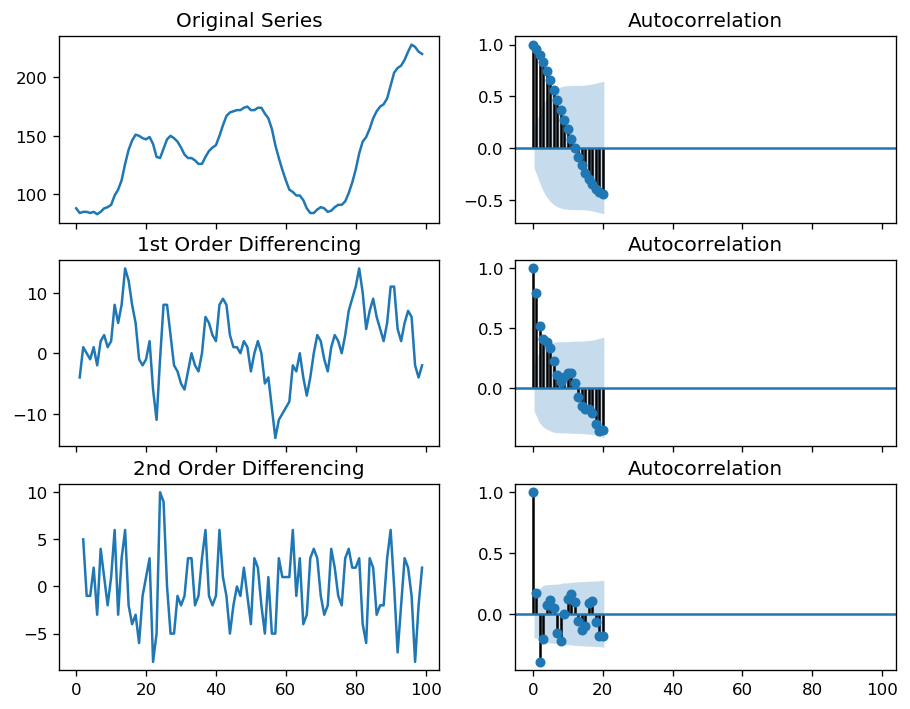

In [10]:
#Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced. so, d=2.

How to find the order of the AR term (p)
The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.
But what is PACF?

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

So what is the formula for PACF mathematically?

Partial autocorrelation of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y.

That is, suppose, if Y_t is the current series and Y_t-1 is the lag 1 of Y, then the partial autocorrelation of lag 3 (Y_t-3) is the coefficient $\alpha_3$ of Y_t-3 in the above equation.

Good. Now, how to find the number of AR terms?

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

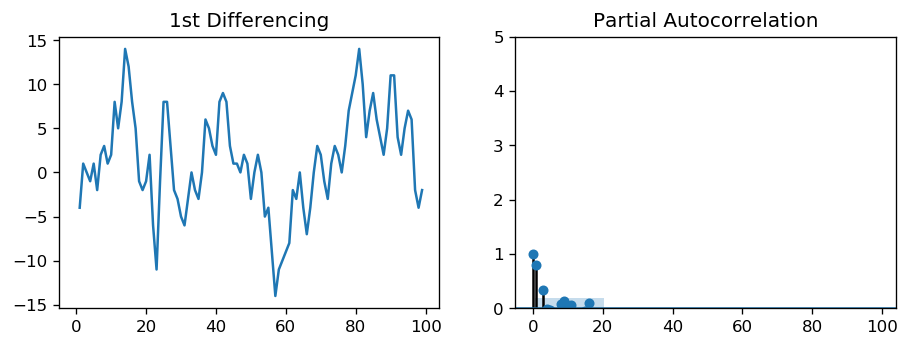

In [11]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

You can observe that the PACF lag 1 is quite significant since is well above the significance line. Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region). But I am going to be conservative and tentatively fix the p as 1.

How to find the order of the MA term (q)
Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

Let’s see the autocorrelation plot of the differenced series.

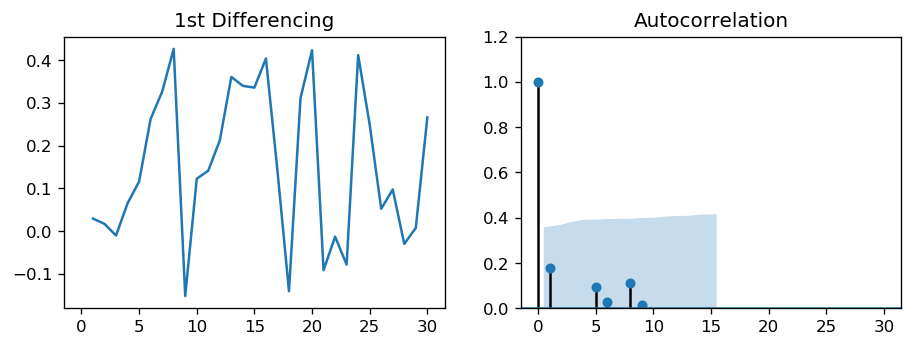

In [12]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/austa.csv')

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

Couple of lags are well above the significance line. So, let’s tentatively fix q as 2. 

In [21]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   30
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  10.649
Method:                       css-mle   S.D. of innovations              0.163
Date:                Wed, 12 May 2021   AIC                             -9.299
Time:                        13:39:09   BIC                             -0.892
Sample:                             1   HQIC                            -6.609
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1564      0.033      4.741      0.000       0.092       0.221
ar.L1.D.value    -0.0830      0.187     -0.444      0.661      -0.450       0.284
ar.L2.D.value    -0.9231      0.105     

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


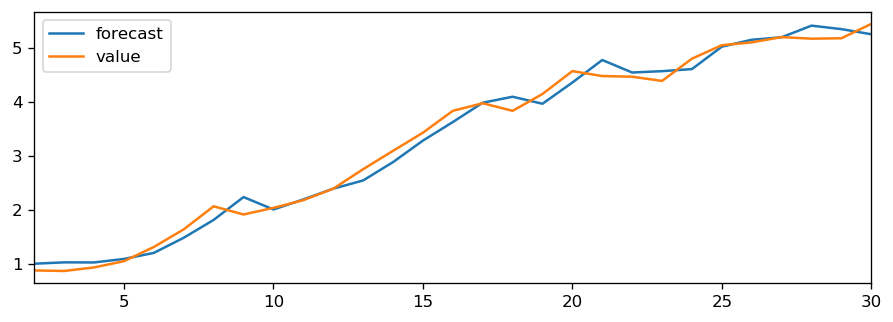

In [22]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

That is, the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.

So, we seem to have a decent ARIMA model. But is that the best?

Can’t say that at this point because we haven’t actually forecasted into the future and compared the forecast with the actual performance.

So, the real validation you need now is the Out-of-Time cross-validation.